In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmaps
import dyl_function_slope as dyl
from matplotlib.colors import BoundaryNorm
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from cartopy.util import add_cyclic_point
ccmap1 = cmaps.NEO_div_vegetation_a
ccmap = cmaps.ncl_default
plt.rcParams['font.family'] = 'Arial'

#1 开始处理数据 加载TI1,VWS,DEF

In [2]:
IN_DIR = "/home/dongyl/Work2_2025/ERA5_daily"
YEARS = list(range(1979, 2024+1))#2015
LAT_MIN, LAT_MAX = 20, 60
Q=0.95
TI_freq_ay = []
VWS_freq_ay = []
DEF_freq_ay = []
u_ay = []

for year in YEARS:
    TI_freq = xr.open_dataset(f"{IN_DIR}/era5_TI1_exceed_pct_{year}_{int(Q * 100)}p.nc")
    freq_subset = TI_freq.sel(lat=slice(10, 80))
    TI_freq = freq_subset["frequency"][::-1]
    TI_freq_ay.append(TI_freq)
    print(f"{year} TI_freq loaded ")

    VWS_freq = xr.open_dataset(f"{IN_DIR}/era5_VWS_exceed_pct_{year}_{int(Q * 100)}p.nc")
    freq_subset = VWS_freq.sel(lat=slice(10, 80))
    VWS_freq = freq_subset["frequency"][::-1]
    VWS_freq_ay.append(VWS_freq)
    print(f"{year} VWS_freq loaded ")

    DEF_freq = xr.open_dataset(f"{IN_DIR}/era5_DEF_exceed_pct_{year}_{int(Q * 100)}p.nc")
    freq_subset = DEF_freq.sel(lat=slice(10, 80))
    DEF_freq = freq_subset["frequency"][::-1]
    DEF_freq_ay.append(DEF_freq)
    print(f"{year} DEF_freq loaded ")

TI_freq_ay_stack = np.stack(TI_freq_ay, axis=0)
VWS_freq_ay_stack = np.stack(VWS_freq_ay, axis=0)
DEF_freq_ay_stack = np.stack(DEF_freq_ay, axis=0)

TI_freq_ay_zonmean = np.nanmean(TI_freq_ay_stack,axis=-1)
VWS_freq_ay_zonmean = np.nanmean(VWS_freq_ay_stack,axis=-1)
DEF_freq_ay_zonmean = np.nanmean(DEF_freq_ay_stack,axis=-1)

TI_freq_trend, TI_freq_p_values = dyl.calculate_trend_3D_ndarray(TI_freq_ay_zonmean)
TI_mask_trend = TI_freq_p_values < 0.05
TI_significant_points= np.where(TI_mask_trend, True, False)
TI_freq_clim = np.nanmean(TI_freq_ay_zonmean,axis=0)
VWS_freq_trend, VWS_freq_p_values = dyl.calculate_trend_3D_ndarray(VWS_freq_ay_zonmean)
VWS_mask_trend = VWS_freq_p_values < 0.05
VWS_significant_points= np.where(VWS_mask_trend, True, False)
VWS_freq_clim = np.nanmean(VWS_freq_ay_zonmean,axis=0)
DEF_freq_trend, DEF_freq_p_values = dyl.calculate_trend_3D_ndarray(DEF_freq_ay_zonmean)
DEF_mask_trend = DEF_freq_p_values < 0.05
DEF_significant_points= np.where(DEF_mask_trend, True, False)
DEF_freq_clim = np.nanmean(DEF_freq_ay_zonmean,axis=0)

1979 TI_freq loaded 
1979 VWS_freq loaded 
1979 DEF_freq loaded 
1980 TI_freq loaded 
1980 VWS_freq loaded 
1980 DEF_freq loaded 
1981 TI_freq loaded 
1981 VWS_freq loaded 
1981 DEF_freq loaded 
1982 TI_freq loaded 
1982 VWS_freq loaded 
1982 DEF_freq loaded 
1983 TI_freq loaded 
1983 VWS_freq loaded 
1983 DEF_freq loaded 
1984 TI_freq loaded 
1984 VWS_freq loaded 
1984 DEF_freq loaded 
1985 TI_freq loaded 
1985 VWS_freq loaded 
1985 DEF_freq loaded 
1986 TI_freq loaded 
1986 VWS_freq loaded 
1986 DEF_freq loaded 
1987 TI_freq loaded 
1987 VWS_freq loaded 
1987 DEF_freq loaded 
1988 TI_freq loaded 
1988 VWS_freq loaded 
1988 DEF_freq loaded 
1989 TI_freq loaded 
1989 VWS_freq loaded 
1989 DEF_freq loaded 
1990 TI_freq loaded 
1990 VWS_freq loaded 
1990 DEF_freq loaded 
1991 TI_freq loaded 
1991 VWS_freq loaded 
1991 DEF_freq loaded 
1992 TI_freq loaded 
1992 VWS_freq loaded 
1992 DEF_freq loaded 
1993 TI_freq loaded 
1993 VWS_freq loaded 
1993 DEF_freq loaded 
1994 TI_freq loaded 
1994

#1.2 加载纬向风数据

In [3]:
ERA5 = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/ua/ERA5_u_1958-2020_288x145_19levels_zonmean.nc').u[22:63,::-1,73:,0]
era5_trend, era5_p_values = dyl.get_slope_p_3D(ERA5)
era5_clim = np.nanmean(ERA5,axis=0)
mask_obs_trend = era5_p_values < 0.05
significant_points_ERA5= np.where(mask_obs_trend, True, False)

/home/dongyl/anaconda3/envs/geocat/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:380: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)


#0. 绘制垂向剖面的函数

In [9]:
def plot_meri_section(ax1, lat,level,level_label,
                      meri_data,meri_data_levels,ccmap,meri_clim,meri_clim_levels,consistency,set_xticks,
                      left_title,colorbar_label,color_bar_ticks,sequence):

    cycle_data, cycle_lat = add_cyclic_point(meri_data, coord=lat)
    lat = np.asarray(lat)
    level = np.asarray(level)
    cycle_lat, cycle_level = np.meshgrid(cycle_lat, np.arange(level.shape[0]))
    #cycle_MON = cycle_MON.filled(np.nan)
    cycle_data = cycle_data.filled(np.nan)

    c1 = ax1.contourf(cycle_lat, cycle_level, cycle_data, cmap=ccmap, levels=meri_data_levels, extend='both')
    cycle_clim, cycle_mon = add_cyclic_point(meri_clim, coord=lat)
    c2 = ax1.contour(cycle_lat, cycle_level, cycle_clim, levels=meri_clim_levels, colors='k', alpha=0.6,
                         linewidths=.8)
    ax1.clabel(c2, inline=True, fontsize=7)

    if consistency is not None:
        cycle_dot, cycle_mon = add_cyclic_point(consistency, coord=lat)
        significance = np.ma.masked_where(cycle_dot == False, cycle_dot)
        c3 = ax1.contourf(cycle_lat, cycle_level, significance, colors='none', hatches=['////'])

        if hasattr(c3, 'collections'):
            collections = c3.collections
        else:
            collections = [c3]
        # 设置 hatch 样式
        for collection in collections:
            collection.set_edgecolor('grey')
            collection.set_linewidth(0)


    ax1.set_xticks(set_xticks)  # 指定要显示的经纬度
    ax1.xaxis.set_major_formatter(LatitudeFormatter())  # 刻度格式转换为经纬度样式
    ax1.yaxis.set_ticks(np.arange(level.shape[0]), level_label)  # 指定要显示的经纬度
    ax1.tick_params(axis='x', labelsize=8)  # 设置x轴刻度数字大小
    ax1.tick_params(axis='y', labelsize=8)  # 设置y轴刻度数字大小
    ax1.text(-0.2, 1.15, sequence, transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
    ax1.set_title(left_title, loc='left', fontsize=9)
    ax1.set_title('ERA5 1979-2024', loc='right', fontsize=9)
    if sequence == 'a':
        ax1.set_ylabel('Level (hPa)', fontsize=8)

    cb = fig.colorbar(c1, orientation='vertical', shrink=0.75, fraction=0.1, pad=0.03, extend='both')
    cb.ax.yaxis.set_major_locator(MultipleLocator(0.2))
    # cb.ax.set_size([0.5,0.2])
    cb.set_ticks(color_bar_ticks)
    cb.ax.tick_params(axis='y', which='major', direction='in', length=6, labelsize=6)
    # cb.ax.tick_params(which='minor', direction='in', length=5)
    cb.set_label(label=colorbar_label, fontsize=8)
    cb.ax.tick_params(labelsize=8)

    return c1

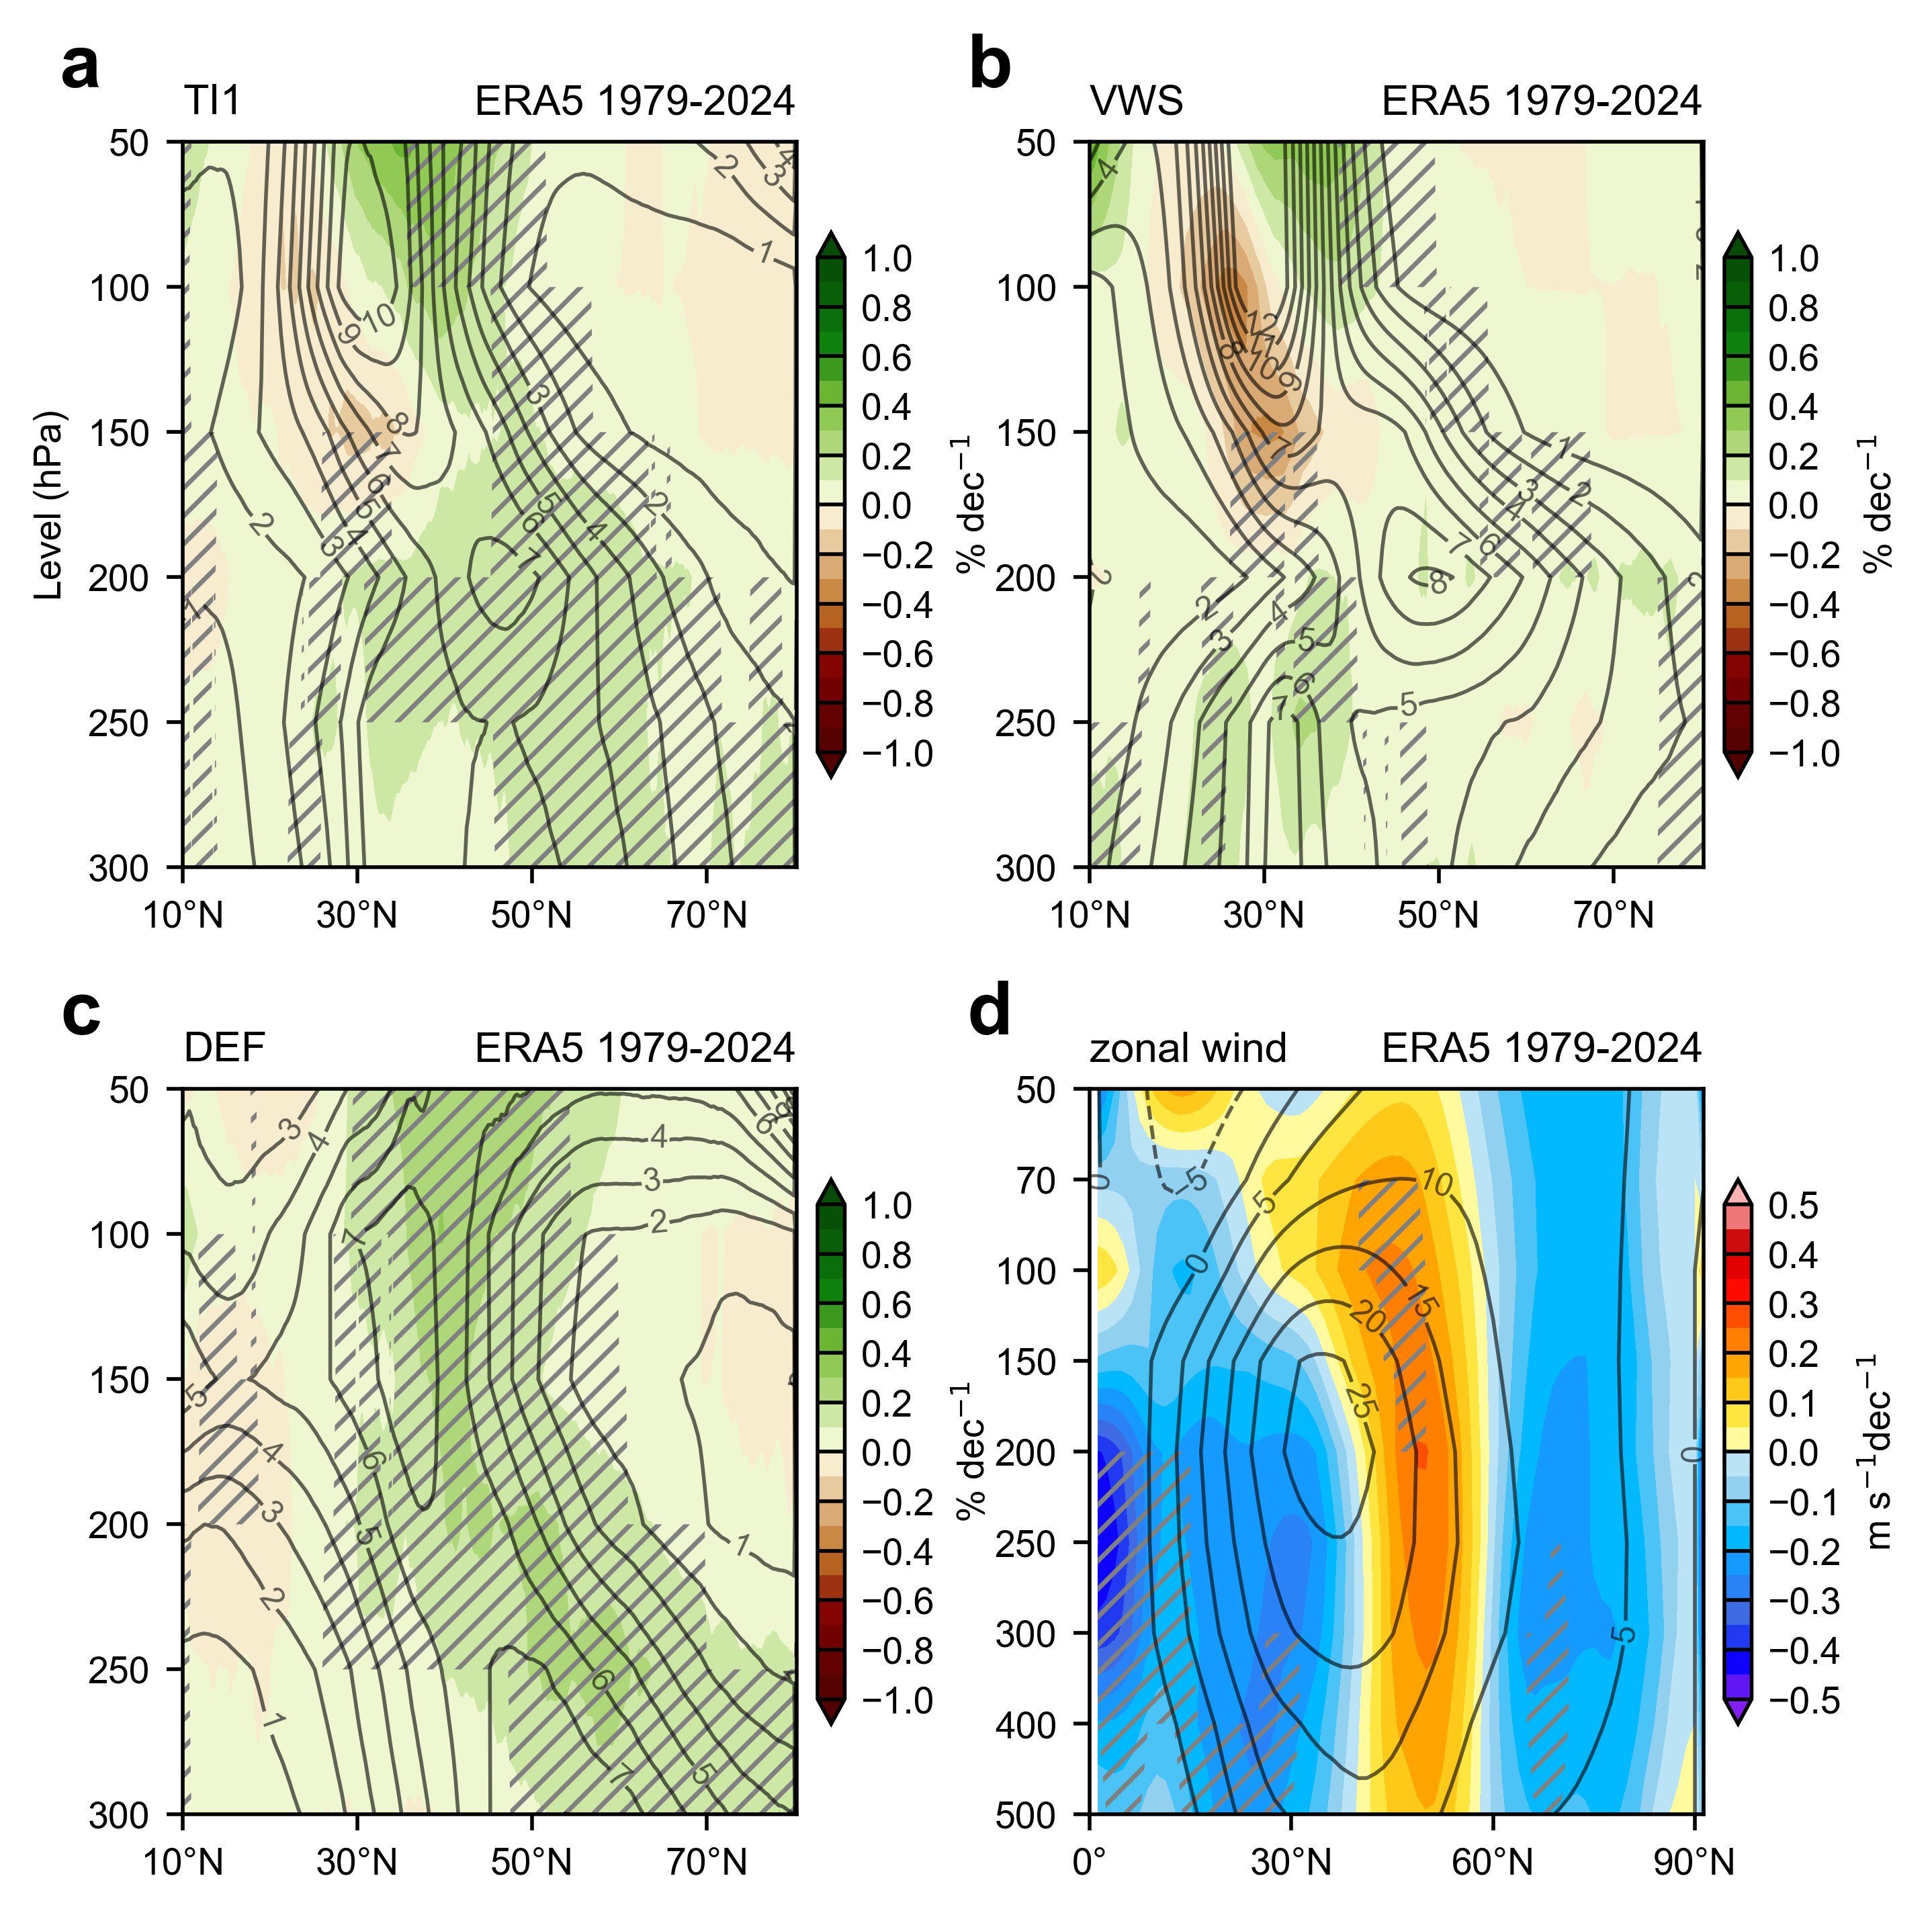

In [10]:
level_label=['300','250','200','150','100','50']
lat = xr.open_dataset(f"{IN_DIR}/era5_TI1_exceed_pct_{year}_{int(Q * 100)}p.nc").lat.values
lat_indices = np.where((lat >= 10) & (lat <= 80))[0]
lat = xr.open_dataset(f"{IN_DIR}/era5_TI1_exceed_pct_{year}_{int(Q * 100)}p.nc").lat[lat_indices].values
level = xr.open_dataset(f"{IN_DIR}/era5_TI1_exceed_pct_{year}_{int(Q * 100)}p.nc").plev[:]

era5_level= ERA5.level[5:14]
era5_level_label = list(map(int, era5_level.data.tolist()))
era5_lat = ERA5.lat.values

fig = plt.figure(figsize=(6, 6), dpi=500)
axes = [[0.1,0.55,0.35,0.36], [0.55,0.55,0.35,0.36],
        [0.1,0.08,0.35,0.36],[0.55,0.08,0.35,0.36]]
plot_meri_section(fig.add_axes(axes[0]), lat,level,level_label,TI_freq_trend*10,np.linspace(-1, 1, 21),ccmap1,TI_freq_clim,
                   np.arange(0, 13, 1),TI_significant_points,np.arange(10,81,20),
                      'TI1','% dec$^{-1}$',np.linspace(-1, 1, 11),'a')
plot_meri_section(fig.add_axes(axes[1]), lat,level,level_label,VWS_freq_trend*10,np.linspace(-1, 1, 21),ccmap1,VWS_freq_clim,
                   np.arange(0, 13, 1),VWS_significant_points,np.arange(10,81,20),
                      'VWS','% dec$^{-1}$',np.linspace(-1, 1, 11),'b')
cf = plot_meri_section(fig.add_axes(axes[2]), lat,level,level_label,DEF_freq_trend*10,np.linspace(-1, 1, 21),ccmap1,DEF_freq_clim,
                   np.arange(0, 13, 1),DEF_significant_points,np.arange(10,81,20),
                      'DEF','% dec$^{-1}$',np.linspace(-1, 1, 11),'c')
cf2 = plot_meri_section(fig.add_axes(axes[3]), era5_lat,era5_level,era5_level_label,era5_trend[5:14]*10,np.arange(-.5,.51, .05),ccmap,era5_clim[5:14],
                   np.arange(-30, 70, 5),significant_points_ERA5[5:14],np.arange(0,91,30),
                      'zonal wind',"m s$^{-1}$"+'dec$^{-1}$',np.arange(-.5,.51, .1),'d')

'''cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.5])  # 调整这些数字以改变colorbar的大小和位置
cb = plt.colorbar(cf,cax=cbar_ax , orientation='vertical', shrink=0.85, pad=0.05, extend='both')
cb.ax.yaxis.set_major_locator(MultipleLocator(0.2))
cb.set_ticks(np.linspace(-0.15, 0.15, 11))
# ax1.tick_params(axis='y', labelsize=8)  # 设置y轴刻度数字大小
cb.ax.tick_params(axis='y', which='major', direction='in', length=3, labelsize=8)
# cb.ax.tick_params(which='minor', direction='in', length=5)
cb.set_label(label='% decade$^{-1}$', fontsize=8)'''

plt.savefig(f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/figures/era5_TI1_VWS_DEF_u_1979-2024_trend_meri_section.png', format='png',dpi=600)
plt.show()